# Extract CMIP6 3D ocean data

Have used this notebook to extract cropped surface and bottom temperature for SSP 245 and 585 for four CMIP6 models: GFDL and CNRM (25km) and IPSL and MOHC (100km). 

In [1]:
# Setup, from Pangeo ESGF search and load notebook
#https://github.com/pangeo-data/pangeo-cmip6-examples/blob/master/search_and_load_with_esgf_opendap.ipynb

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Additional setup code from Pangeo example for getting data from the server
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [3]:
# function to find deepest value

# write this as a function
def find_deepest_value(x):
    # finds the last non-NA value in a vector
    
    # get error if every value in the input is NAN, so need an if else
    if np.isnan(x).all():
        # return an NA if the input is all NA
        y = np.nan
    else: 
        # find the maximum (deepest) value where input is defined
        y = x[np.max (np.where(np.isfinite(x)))]
    return y

Code for checking outputs:

Check size: ipsl_hist.nbytes/1e6
Check dimensions: ispl_hist.thetao.shape
Plot: ipsl_245.thetao.isel(time=0, olevel = 0).squeeze().plot() # don't always need squeeze?
gfdl_hist_bt.thetao.isel(month = 0).plot()

### IPSL

Kept getting errors and access failures with this one, but worked successfully with this same code on my local machine.

In [4]:
# Specify model and create list of filenames. Doesn't appear to work by dataset ID, so fill in all the specifications as in the pangeo example

ipsl_hist_files = esgf_search(activity_id='CMIP', table_id='Omon', variable_id='thetao', experiment_id='historical',
                  institution_id="IPSL", source_id="IPSL-CM6A-LR", member_id="r1i1p1f1", nominal_resolution = "100 km")

#ipsl_hist_files # two files

%time ipsl_hist = xr.open_mfdataset(ipsl_hist_files[0:2], combine = "by_coords") # 18.9s on rsch101
ipsl_hist # 2854 MB, lev is olevel, x 362 by y 332 by time 1032 by olevel 75

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable_id=thetao&experiment_id=historical&institution_id=IPSL&source_id=IPSL-CM6A-LR&member_id=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
Wall time: 56.5 s


u:\documents\conda_dir\myenv1\lib\site-packages\dask\array\core.py:1274: RuntimeWarning: overflow encountered in long_scalars
  cbytes = format_bytes(np.prod(self.chunksize) * self.dtype.itemsize)


<xarray.Dataset>
Dimensions:         (axis_nbounds: 2, nvertex: 4, olevel: 75, time: 1980, x: 362, y: 332)
Coordinates:
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * olevel          (olevel) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_nav_lon  (time, y, x, nvertex) float32 dask.array<chunksize=(1200, 332, 362, 4), meta=np.ndarray>
    bounds_nav_lat  (time, y, x, nvertex) float32 dask.array<chunksize=(1200, 332, 362, 4), meta=np.ndarray>
    area            (time, y, x) float32 dask.array<chunksize=(1200, 332, 362), meta=np.ndarray>
    olevel_bounds   (time, olevel, axis_nbounds) float32 dask.array<chunksize=(1200, 75, 2), meta=np.ndarray>
    time_bounds     (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1200, 2), meta=np.ndarray>
    thetao          (time, olevel, y, x) float32 dask.array<chunksize=(1200, 75, 332, 362), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-07-11T07:36:16Z
    tracking_id:                     hdl:21.14100/2357970e-3f77-4595-80d8-e3d...
    description:                     CMIP6 historical
    title:                           IPSL-CM6A-LR model output prepared for C...
    activity_id:                     CMIP
    contact:                         ipsl-cmip6@listes.ipsl.fr
    data_specs_version:              01.00.21
    dr2xml_version:                  1.11
    experiment_id:                   historical
    experiment:                      all-forcing simulation of the recent past
    external_variables:              areacello volcello
    forcing_index:                   1
    frequency:                       mon
    grid:                            native ocean tri-polar grid with 105 k o...
    grid_label:                      gn
    nominal_resolution:              100 km
    initialization_index:            1
    institution_id:                  IPSL
    institution:                     Institut Pierre Simon Laplace, Paris 752...
    license:                         CMIP6 model data produced by IPSL is lic...
    mip_era:                         CMIP6
    parent_experiment_id:            piControl
    parent_mip_era:                  CMIP6
    parent_activity_id:              CMIP
    parent_source_id:                IPSL-CM6A-LR
    parent_time_units:               days since 1850-01-01 00:00:00
    branch_method:                   standard
    branch_time_in_parent:           21914.0
    branch_time_in_child:            0.0
    physics_index:                   1
    product:                         model-output
    realm:                           ocean
    source:                          IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6,...
    source_id:                       IPSL-CM6A-LR
    source_type:                     AOGCM BGC
    sub_experiment_id:               none
    sub_experiment:                  none
    table_id:                        Omon
    variable_id:                     thetao
    EXPID:                           historical
    CMIP6_CV_version:                cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:                   f1e40c1fc5d8281f865f72fbf4e38f9d
    model_version:                   6.1.5
    parent_variant_label:            r1i1p1f1
    name:                            /ccc/work/cont003/gencmip6/p86caub/IGCM_...
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.IPS...
    variant_label:                   r1i1p1f1
    realization_index:               1
    history:                         Sat Dec  1 12:16:38 2018: ncatted -O -a ...
    NCO:                             "4.6.0"
    DODS_EXTRA.Unlimited_Dimension:  time

In [12]:
# Take crude crop for projections (defined below for 245), and take a monthly mean. Just need 1982-2011 to match with OISST climatology. Slice doesn't do the weird python indexing; just say the years you want
ipsl_hist_crop = ipsl_hist.thetao.sel(time = slice ('1982', '2011'), x = slice (240, 300), y = slice (250, 320)).groupby('time.month').mean('time')

%time ipsl_hist_crop.isel(olevel = 0).to_netcdf('ipsl_hist_sst_crop.nc')

u:\documents\conda_dir\myenv1\lib\site-packages\xarray\core\common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [13]:
# find and save bottom temp
%time ipsl_hist_bt = xr.apply_ufunc(find_deepest_value, ipsl_hist_crop, input_core_dims = [['olevel']], dask = 'allowed', vectorize = True)

ipsl_hist_bt.to_netcdf('ipsl_hist_bt_crop.nc')

u:\documents\conda_dir\myenv1\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Wall time: 3min 1s
Wall time: 706 ms


### IPSL 245

In [5]:
# Specify model and create list of filenames. Doesn't appear to work by dataset ID, so fill in all the specifications as in the pangeo example

ipsl_245_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp245',
                  institution_id="IPSL", source_id="IPSL-CM6A-LR", member_id="r1i1p1f1", nominal_resolution = "100 km")

#ipsl_245_files
# low-res dataset, so only one file needed. Gives two different sources; use the first one

%time ipsl_245 = xr.open_dataset(ipsl_245_files[0]) # 18.9s on rsch101
ipsl_245 # 2854 MB, lev is olevel, x 362 by y 332 by time 1032 by olevel 75

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp245&institution_id=IPSL&source_id=IPSL-CM6A-LR&member_id=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
Wall time: 1.57 s


<xarray.Dataset>
Dimensions:         (axis_nbounds: 2, nvertex: 4, olevel: 75, time: 1032, x: 362, y: 332)
Coordinates:
    nav_lat         (y, x) float32 ...
    nav_lon         (y, x) float32 ...
  * olevel          (olevel) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * time            (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 ...
    bounds_nav_lat  (y, x, nvertex) float32 ...
    area            (y, x) float32 ...
    olevel_bounds   (olevel, axis_nbounds) float32 ...
    time_bounds     (time, axis_nbounds) datetime64[ns] ...
    thetao          (time, olevel, y, x) float32 ...
Attributes:
    name:                            /ccc/work/cont003/gencmip6/lurtont/IGCM_...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-12-05T17:25:51Z
    tracking_id:                     hdl:21.14100/f430e24b-6e7f-4e9c-a87d-6eb...
    description:                     Future scenario with medium radiative fo...
    title:                           IPSL-CM6A-LR model output prepared for C...
    activity_id:                     ScenarioMIP
    contact:                         ipsl-cmip6@listes.ipsl.fr
    data_specs_version:              01.00.28
    dr2xml_version:                  1.16
    experiment_id:                   ssp245
    experiment:                      update of RCP4.5 based on SSP2
    external_variables:              areacello volcello
    forcing_index:                   1
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.IPS...
    grid:                            native ocean tri-polar grid with 105 k o...
    grid_label:                      gn
    nominal_resolution:              100 km
    history:                         none
    initialization_index:            1
    institution_id:                  IPSL
    institution:                     Institut Pierre Simon Laplace, Paris 752...
    license:                         CMIP6 model data produced by IPSL is lic...
    mip_era:                         CMIP6
    parent_experiment_id:            historical
    parent_mip_era:                  CMIP6
    parent_activity_id:              CMIP
    parent_source_id:                IPSL-CM6A-LR
    parent_time_units:               days since 1850-01-01 00:00:00
    parent_variant_label:            r1i1p1f1
    branch_method:                   standard
    branch_time_in_parent:           60265.0
    branch_time_in_child:            0.0
    physics_index:                   1
    product:                         model-output
    realization_index:               1
    realm:                           ocean
    source:                          IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6,...
    source_id:                       IPSL-CM6A-LR
    source_type:                     AOGCM BGC
    sub_experiment_id:               none
    sub_experiment:                  none
    table_id:                        Omon
    variable_id:                     thetao
    variant_info:                    Each member starts from the correspondin...
    variant_label:                   r1i1p1f1
    EXPID:                           ssp245
    CMIP6_CV_version:                cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:                   c2dce418e78ca835be1e2ff817c2c403
    model_version:                   6.1.8
    DODS_EXTRA.Unlimited_Dimension:  time

In [24]:
# crude crop around Iceland's waters based on looking at the map
ipsl_245_crop = ipsl_245.thetao.sel(x = slice (240, 300), y = slice (250, 320))

%time ipsl_245_crop.isel(olevel = 0).to_netcdf('ipsl_245_sst_crop.nc')

# find and save bottom temp
%time ipsl_245_bt = xr.apply_ufunc(find_deepest_value, ipsl_245_crop, input_core_dims = [['olevel']], dask = 'allowed', vectorize = True)
ipsl_245_bt.to_netcdf ('ipsl_245_bt_crop.nc')

Wall time: 8min 22s


### IPSL 585

In [4]:
ipsl_585_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp585',
                  institution_id="IPSL", source_id="IPSL-CM6A-LR", member_id="r1i1p1f1", nominal_resolution = "100 km")

%time ipsl_585 = xr.open_dataset(ipsl_585_files[0], chunks = {'time':100}) 
ipsl_585.nbytes/1e6 # 2854 MB, lev is olevel

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp585&institution_id=IPSL&source_id=IPSL-CM6A-LR&member_id=r1i1p1f1&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
Wall time: 22.4 s


2854.541796

In [ ]:
# crude crop around Iceland's waters based on looking at the map
ipsl_585_crop = ipsl_585.thetao.sel(x = slice (240, 300), y = slice (250, 320))

%time ipsl_585_crop.isel(olevel = 0).to_netcdf('ipsl_585_sst_crop.nc')

%time ipsl_585_bt = xr.apply_ufunc(find_deepest_value, ipsl_585_crop, input_core_dims = [['olevel']], dask = 'allowed', vectorize = True)
ipsl_585_bt.to_netcdf ('ipsl_585_bt_crop.nc')

### CNRM 

In [12]:
cnrm_hist_files = esgf_search(activity_id= 'CMIP', table_id='Omon', variable_id='thetao', experiment_id='historical',
                  institution_id="CNRM-CERFACS", source_id="CNRM-CM6-1-HR", member_id="r1i1p1f2", nominal_resolution = "25 km")

#cnrm_hist_files # 33, want last 6
# len (cnrm_hist_files)

%time cnrm_hist = xr.open_mfdataset(cnrm_hist_files[-6:], combine='by_coords', chunks = {'x':50, 'y':50})

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable_id=thetao&experiment_id=historical&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1-HR&member_id=r1i1p1f2&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable_id=thetao&experiment_id=historical&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1-HR&member_id=r1i1p1f2&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable_id=thetao&experiment_id=historical&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1-HR&member_id=r1i1p1f2&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable_id=thetao&experiment_

In [16]:
cnrm_hist_mn_crop = cnrm_hist.thetao.sel(time = slice ('1982', '2011'), x = slice (975, 1190), y = slice (750, 1005)).groupby('time.month').mean('time')

cnrm_hist_mn_crop.isel(lev = 0).to_netcdf ('cnrm_hist_sst_crop.nc')

# Find bottom temp
%time cnrm_hist_bt = xr.apply_ufunc(find_deepest_value, cnrm_hist_mn_crop, input_core_dims = [['lev']], dask = 'allowed', vectorize = True)
cnrm_hist_bt.to_netcdf ('cnrm_hist_bt_crop.nc')

\\rschfs1x\userrs\F-J\jgm278_RS\AppData\Roaming\Python\Python37\site-packages\xarray\core\common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


RuntimeError: NetCDF: DAP failure

### CNRM 245

In [3]:
cnrm_245_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp245',
                  institution_id="CNRM-CERFACS", source_id="CNRM-CM6-1-HR", member_id="r1i1p1f2", nominal_resolution = "25 km")

# 19 files
%time cnrm_245 = xr.open_mfdataset(cnrm_245_files[0:18], combine='by_coords', chunks = {'time':15})

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp245&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1-HR&member_id=r1i1p1f2&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp245&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1-HR&member_id=r1i1p1f2&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp245&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1-HR&member_id=r1i1p1f2&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=th

In [8]:
# Crude crop around Iceland's waters
cnrm_245_crop = cnrm_245.thetao.sel(x=slice(975, 1190), y=slice(750,1005))

# save sst
% time cnrm_245_crop.isel(lev = 0).to_netcdf('cnrm_245_sst_crop.nc')# 1 h 7 min
# Find bottom temp
%time cnrm_245_crop = xr.apply_ufunc(find_deepest_value, cnrm_245_3d, input_core_dims = [['lev']], dask = 'allowed', vectorize = True)

%time cnrm_245_crop.to_netcdf('cnrm_245_bt_crop.nc')

Wall time: 3.14 s


### CNRM 585

In [3]:
cnrm_585_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp585',
                  institution_id="CNRM-CERFACS", source_id="CNRM-CM6-1-HR", member_id="r1i1p1f2", nominal_resolution = "25 km")

%time cnrm_585 = xr.open_mfdataset(cnrm_585_files[0:18], combine='by_coords', chunks = {'time':15})

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp585&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1-HR&member_id=r1i1p1f2&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp585&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1-HR&member_id=r1i1p1f2&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp585&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1-HR&member_id=r1i1p1f2&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=th

In [4]:
# redo 585 SST, I deleted it??
%time cnrm_585.thetao.isel(lev = 0).sel(x=slice(975, 1190), y=slice(750,1005)).to_netcdf('cnrm_585_sst_crop.nc')

Wall time: 1h 8min 55s


suspicious situation, cnrm 245 and 585 identical

In [8]:
# look at cnrm 585 vs 245, check if identical? 
cnrm_585 = xr.open_dataset('cnrm_585_sst_crop.nc')
cnrm_585.thetao[:5, :5]

<xarray.DataArray 'thetao' (time: 5, y: 5, x: 215)>
array([[[3.410762, 3.800278, ...,      nan,      nan],
        [3.514991, 3.918941, ...,      nan,      nan],
        ...,
        [3.946448, 4.321306, ...,      nan,      nan],
        [4.152283, 4.428981, ...,      nan,      nan]],

       [[2.820315, 3.14211 , ...,      nan,      nan],
        [2.925672, 3.265206, ...,      nan,      nan],
        ...,
        [3.49731 , 3.805434, ...,      nan,      nan],
        [3.830939, 3.99646 , ...,      nan,      nan]],

       ...,

       [[3.43874 , 3.627099, ...,      nan,      nan],
        [3.500489, 3.694199, ...,      nan,      nan],
        ...,
        [3.736345, 3.826491, ...,      nan,      nan],
        [3.765524, 3.798183, ...,      nan,      nan]],

       [[5.157847, 5.36171 , ...,      nan,      nan],
        [5.194062, 5.387777, ...,      nan,      nan],
        ...,
        [5.402027, 5.507457, ...,      nan,      nan],
        [5.447816, 5.477609, ...,      nan,      nan]]], dtype=float32)
Coordinates:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
    lev      float64 ...
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2015-05-16T12:00:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           Sea Water Potential Temperature
    units:               degC
    online_operation:    average
    cell_methods:        area: mean where sea time: mean
    interval_operation:  900 s
    interval_write:      1 month
    description:         Diagnostic should be contributed even for models usi...
    history:             none
    cell_measures:       area: areacello volume: volcello
    _ChunkSizes:         [   1   75 1050 1442]

In [9]:
cnrm_245 = xr.open_dataset('cnrm_245_sst_crop.nc')
cnrm_245.thetao[:5, :5] # different!!!

<xarray.DataArray 'thetao' (time: 5, y: 5, x: 215)>
array([[[3.511687, 3.915709, ...,      nan,      nan],
        [3.651127, 4.030331, ...,      nan,      nan],
        ...,
        [3.998292, 4.256465, ...,      nan,      nan],
        [4.113178, 4.282605, ...,      nan,      nan]],

       [[2.148408, 2.486272, ...,      nan,      nan],
        [2.234716, 2.596639, ...,      nan,      nan],
        ...,
        [2.597785, 2.867834, ...,      nan,      nan],
        [2.774399, 2.857539, ...,      nan,      nan]],

       ...,

       [[3.101951, 3.228342, ...,      nan,      nan],
        [3.125468, 3.277653, ...,      nan,      nan],
        ...,
        [3.235363, 3.365342, ...,      nan,      nan],
        [3.294842, 3.322373, ...,      nan,      nan]],

       [[4.967993, 4.988977, ...,      nan,      nan],
        [4.987106, 5.062588, ...,      nan,      nan],
        ...,
        [5.0943  , 5.134128, ...,      nan,      nan],
        [5.042999, 5.014448, ...,      nan,      nan]]], dtype=float32)
Coordinates:
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
    lev      float64 ...
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2015-05-16T12:00:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           Sea Water Potential Temperature
    units:               degC
    online_operation:    average
    cell_methods:        area: mean where sea time: mean
    interval_operation:  900 s
    interval_write:      1 month
    description:         Diagnostic should be contributed even for models usi...
    history:             none
    cell_measures:       area: areacello volume: volcello
    _ChunkSizes:         [   1   75 1050 1442]

Can I just take a really crude crop? Like x is between 950-1250 and y is greater than 700?

In [6]:
cnrm_585_crop = cnrm_585.thetao.sel(x=slice(975, 1190), y=slice(750,1005))

%time cnrm_585_crop.isel (lev = 0).to_netcdf('cnrm_585_sst_crop.nc')

%time cnrm_585_bt = xr.apply_ufunc(find_deepest_value, cnrm_585_crop, input_core_dims = [['lev']], dask = 'allowed', vectorize = True)
cnrm_585_bt.to_netcdf ('cnrm_585_bt_crop.nc')

Wall time: 2h 48min 34s


### MOHC

### MOHC 245

In [7]:
mohc_245_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp245',
                  institution_id="MOHC", source_id="HadGEM3-GC31-LL", member_id="r1i1p1f3", nominal_resolution = "100 km")

%time mohc_245 = xr.open_mfdataset(mohc_245_files[0:3], combine='by_coords', chunks = {'time':15})

mohc_245

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, lev: 75, time: 1020, vertices: 4)
Coordinates:
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * time                (time) object 2015-01-16 00:00:00 ... 2099-12-16 00:00:00
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(15, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 dask.array<chunksize=(420, 75, 2), meta=np.ndarray>
    vertices_latitude   (time, j, i, vertices) float32 dask.array<chunksize=(420, 330, 360, 4), meta=np.ndarray>
    vertices_longitude  (time, j, i, vertices) float32 dask.array<chunksize=(420, 330, 360, 4), meta=np.ndarray>
    thetao              (time, lev, j, i) float32 dask.array<chunksize=(15, 75, 330, 360), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     ScenarioMIP
    branch_method:                   standard
    branch_time_in_child:            59400.0
    branch_time_in_parent:           59400.0
    creation_date:                   2019-09-06T15:21:25Z
    cv_version:                      6.2.20.1
    data_specs_version:              01.00.29
    experiment:                      update of RCP4.5 based on SSP2
    experiment_id:                   ssp245
    external_variables:              areacello volcello
    forcing_index:                   3
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.MOH...
    grid:                            Native eORCA1 tripolar primarily 1 deg w...
    grid_label:                      gn
    history:                         2019-09-06T15:10:46Z ; CMOR rewrote data...
    initialization_index:            1
    institution:                     Met Office Hadley Centre, Fitzroy Road, ...
    institution_id:                  MOHC
    mip_era:                         CMIP6
    mo_runid:                        u-bj616
    nominal_resolution:              100 km
    parent_activity_id:              CMIP
    parent_experiment_id:            historical
    parent_mip_era:                  CMIP6
    parent_source_id:                HadGEM3-GC31-LL
    parent_time_units:               days since 1850-01-01-00-00-00
    parent_variant_label:            r1i1p1f3
    physics_index:                   1
    product:                         model-output
    realization_index:               1
    realm:                           ocean
    source:                          HadGEM3-GC31-LL (2016): \naerosol: UKCA-...
    source_id:                       HadGEM3-GC31-LL
    source_type:                     AOGCM AER
    sub_experiment:                  none
    sub_experiment_id:               none
    table_id:                        Omon
    table_info:                      Creation Date:(13 December 2018) MD5:2b1...
    title:                           HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:                     hdl:21.14100/98bdbf2e-b354-44cf-ae9d-874...
    variable_id:                     thetao
    variable_name:                   thetao
    variant_label:                   r1i1p1f3
    license:                         CMIP6 model data produced by the Met Off...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

In [13]:
mohc_245_crop = mohc_245.thetao.sel(i = slice (240, 300), j = slice(250, 320))

%time mohc_245_crop.isel(lev = 0).to_netcdf('mohc_245_sst_crop.nc')

%time mohc_245_bt = xr.apply_ufunc(find_deepest_value, mohc_245_crop, input_core_dims = [['lev']], dask = 'allowed', vectorize = True)
mohc_245_bt.to_netcdf ('mohc_245_bt_crop.nc')

Wall time: 10min 24s


### MOHC 585

In [20]:
mohc_585_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp585',
                  institution_id="MOHC", source_id="HadGEM3-GC31-LL", member_id="r1i1p1f3", nominal_resolution = "100 km")

#mohc_585_files
%time mohc_585 = xr.open_mfdataset(mohc_585_files[0:3], combine='by_coords', chunks = {'time':15})

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp585&institution_id=MOHC&source_id=HadGEM3-GC31-LL&member_id=r1i1p1f3&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
Wall time: 4.64 s


In [ ]:
mohc_585_crop = mohc_585.thetao.sel(i = slice (240, 300), j = slice(250, 320))

%time mohc_585_crop.isel(lev = 0).to_netcdf('mohc_585_sst_crop.nc')

%time mohc_585_bt = xr.apply_ufunc(find_deepest_value, mohc_585_crop, input_core_dims = [['lev']], dask = 'allowed', vectorize = True)
mohc_585_bt.to_netcdf ('mohc_585_bt_crop.nc')

### MOHC historical. 
originally did this on local machine on 7/27

In [14]:
mohc_hist_files = esgf_search(activity_id='CMIP', table_id='Omon', variable_id='thetao', experiment_id='historical',
                  institution_id="MOHC", source_id="HadGEM3-GC31-LL", member_id="r1i1p1f3", nominal_resolution = "100 km")

%time mohc_hist = xr.open_mfdataset(mohc_hist_files[-2:], combine='by_coords', chunks = {'time':15})

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable_id=thetao&experiment_id=historical&institution_id=MOHC&source_id=HadGEM3-GC31-LL&member_id=r1i1p1f3&nominal_resolution=100 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
Wall time: 94 ms


In [15]:
# crop and then save as sst and bt
mohc_hist_crop = mohc_hist.thetao.sel(time = slice ('1982', '2011'), i = slice (240, 300), j = slice (250, 320)).groupby('time.month').mean('time')

%time mohc_hist_crop.isel(lev = 0).to_netcdf('mohc_hist_sst_crop.nc')

# find bt and save
%time mohc_hist_bt = xr.apply_ufunc(find_deepest_value, mohc_hist_crop, input_core_dims = [['lev']], dask = 'allowed', vectorize = True)
%time mohc_hist_bt.to_netcdf('mohc_hist_bt_crop.nc')

u:\documents\conda_dir\myenv1\lib\site-packages\xarray\core\common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
u:\documents\conda_dir\myenv1\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Wall time: 3min 47s


u:\documents\conda_dir\myenv1\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Wall time: 3min 16s
Wall time: 2.37 s


### Try with GFDL, compare with local machine

### GFDL historical

In [ ]:
# historical
gfdl_hist_files = esgf_search(activity_id='CMIP', table_id='Omon', variable_id='thetao', experiment_id='historical',
                  institution_id="NOAA-GFDL", source_id="GFDL-CM4", member_id="r1i1p1f1", nominal_resolution = "25 km")
gfdl_hist = xr.open_mfdataset(gfdl_hist_files[-3:], combine='by_coords', chunks = {'time':15})

In [12]:
gfdl_hist_crop = gfdl_hist.thetao.sel(time = slice ('1982', '2011'), x=slice(-45, 15), y=slice(50, 85)).groupby('time.month').mean('time')
%time gfdl_hist_crop.isel(lev = 0).to_netcdf('gfdl_hist_sst_crop.nc')

%time gfdl_hist_bt = xr.apply_ufunc(find_deepest_value, gfdl_hist_crop, input_core_dims = [['lev']], dask = 'allowed', vectorize = True)
gfdl_hist_bt.to_netcdf ('gfdl_hist_bt_crop.nc')

u:\documents\conda_dir\myenv1\lib\site-packages\xarray\core\common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
u:\documents\conda_dir\myenv1\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### GFDL 245

In [10]:
# Search ESGF site for GFDL SSP 245 by dataset ID, gives connection error
gfdl_245_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp245',
                  institution_id="NOAA-GFDL", source_id="GFDL-CM4", member_id="r1i1p1f1", nominal_resolution = "25 km")
#gfdl_245_files[0:5] # both aims and esgf

%time gfdl_245 = xr.open_mfdataset(gfdl_245_files[0:5],combine='by_coords', chunks = {'time':10}) # 29.3s w/o chunks, 489ms with chunks 10
gfdl_245

Wall time: 489 ms


u:\documents\conda_dir\myenv1\lib\site-packages\dask\array\core.py:1274: RuntimeWarning: overflow encountered in long_scalars
  cbytes = format_bytes(np.prod(self.chunksize) * self.dtype.itemsize)


<xarray.Dataset>
Dimensions:    (bnds: 2, lev: 35, time: 1032, vertex: 4, x: 1440, y: 1080)
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * bnds       (bnds) float64 1.0 2.0
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: vertex
Data variables:
    lat_bnds   (time, y, x, vertex) float32 dask.array<chunksize=(240, 1080, 1440, 4), meta=np.ndarray>
    lon_bnds   (time, y, x, vertex) float32 dask.array<chunksize=(240, 1080, 1440, 4), meta=np.ndarray>
    thetao     (time, lev, y, x) float32 dask.array<chunksize=(10, 35, 1080, 1440), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(240, 35, 2), meta=np.ndarray>
Attributes:
    title:                           NOAA GFDL GFDL-CM4 model output prepared...
    external_variables:              areacello volcello
    history:                         File was processed by fremetar (GFDL ana...
    table_id:                        Omon
    activity_id:                     ScenarioMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    comment:                         <null ref>
    contact:                         gfdl.climate.model.info@noaa.gov
    Conventions:                     CF-1.7 CMIP-6.0 UGRID-1.0
    creation_date:                   2019-03-18T07:31:12Z
    data_specs_version:              01.00.27
    experiment:                      update of RCP4.5 based on SSP2
    experiment_id:                   ssp245
    forcing_index:                   1
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NOA...
    grid:                            ocean data on native grid tripolar - nom...
    grid_label:                      gn
    initialization_index:            1
    institution:                     National Oceanic and Atmospheric Adminis...
    institution_id:                  NOAA-GFDL
    license:                         CMIP6 model data produced by NOAA-GFDL i...
    mip_era:                         CMIP6
    nominal_resolution:              25 km
    parent_activity_id:              CMIP
    parent_experiment_id:            historical
    parent_mip_era:                  CMIP6
    parent_source_id:                GFDL-CM4
    parent_variant_label:            r1i1p1f1
    physics_index:                   1
    product:                         model-output
    realization_index:               1
    realm:                           ocean
    source:                          GFDL-CM4 (2018): \naerosol: interactive\...
    source_id:                       GFDL-CM4
    source_type:                     AOGCM
    sub_experiment:                  none
    sub_experiment_id:               none
    tracking_id:                     hdl:21.14100/60c1a030-123e-4104-a57d-821...
    variable_id:                     thetao
    variant_info:                    N/A
    references:                      see further_info_url attribute
    variant_label:                   r1i1p1f1
    branch_time_in_parent:           60225.0
    parent_time_units:               days since 1850-1-1
    DODS_EXTRA.Unlimited_Dimension:  time

In [12]:
# crop and then save as sst and bt
gfdl_245_crop = gfdl_245.thetao.sel(x=slice(-45, 15), y=slice(50, 85))

%time gfdl_245_crop.isel(lev = 0).to_netcdf ('gfdl_sst_245_crop.nc') # 10min 55s on rsch101 vs 15min on local machine

%time gfdl_245_bt = xr.apply_ufunc(find_deepest_value, gfdl_245_crop, input_core_dims = [['lev']], dask = 'allowed', vectorize = True)
%time gfdl_245_bt.to_netcdf ('gfdl_bt_245_crop.nc')

Wall time: 10min 55s


### GFDL 585

In [10]:
gfdl_585_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp585',
                  institution_id="NOAA-GFDL", source_id="GFDL-CM4", member_id="r1i1p1f1", nominal_resolution = "25 km")

%time gfdl_585 = xr.open_mfdataset(gfdl_585_files[0:5],combine='by_coords', chunks = {'time':10}) # 29.3s w/o chunks, 489ms with chunks 10

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp585&institution_id=NOAA-GFDL&source_id=GFDL-CM4&member_id=r1i1p1f1&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
Wall time: 28.2 s


In [12]:
gfdl_585_crop = gfdl_585.thetao.sel(x = slice (-45, 15), y = slice(50, 85))

%time gfdl_585_crop.isel(lev = 0).to_netcdf('gfdl_585_sst_crop.nc')
%time gfdl_585_bt = xr.apply_ufunc(find_deepest_value, gfdl_585_crop, input_core_dims = [['lev']], dask = 'allowed', vectorize = True)

%time gfdl_585_bt.to_netcdf('gfdl_585_bt_crop.nc')

Wall time: 1h 55min 24s


### AWI
just for kicks

In [35]:
awi_245_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp245',
                  institution_id="AWI", source_id="AWI-CM-1-1-MR", member_id="r1i1p1f1", nominal_resolution = "25 km")

#awi_245_files[0:9]
%time awi_245 = xr.open_mfdataset(awi_245_files[0:9], combine='by_coords', chunks = {'time':15})

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp245&institution_id=AWI&source_id=AWI-CM-1-1-MR&member_id=r1i1p1f1&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=thetao&experiment_id=ssp245&institution_id=AWI&source_id=AWI-CM-1-1-MR&member_id=r1i1p1f1&nominal_resolution=25 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
Wall time: 1min 11s


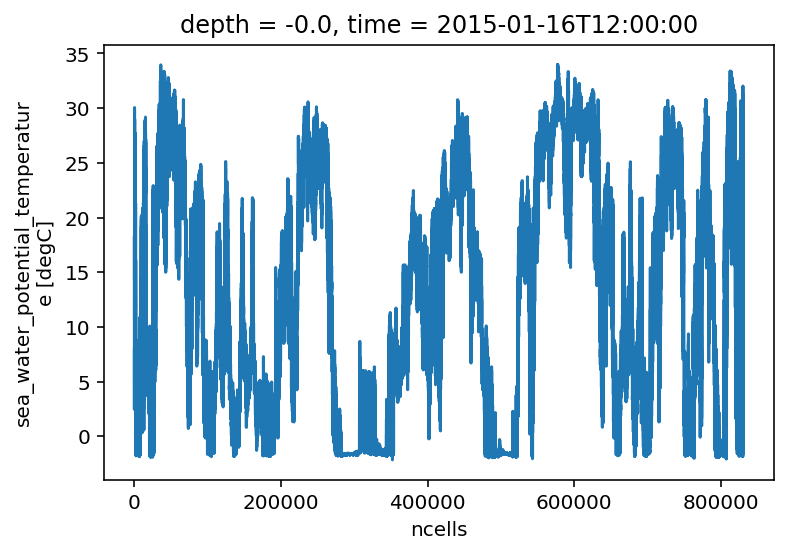

In [37]:
awi_245 # 1032 time by 46 depth by 830305
awi_245.thetao.isel(time = 0, depth = 0).plot() # looks like a time series

In [16]:
awi_245_sst_glob = awi_245.thetao.isel(depth = 0)
%time awi_245_sst_glob.to_netcdf ('awi_245_sst_glob.nc')
# ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (15,830305) and requested shape (15,330,360)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (15,830305) and requested shape (15,330,360)

In [39]:
awi_245_nc = xr.open_dataset('awi_245_sst_glob.nc')

In [41]:
awi_245_nc # empty?

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [40]:
# access failure
%time awi_245_bt = xr.apply_ufunc(find_deepest_value, awi_245_nc.thetao, input_core_dims = [['depth']], dask = 'allowed', vectorize = True)

AttributeError: 'Dataset' object has no attribute 'thetao'

In [ ]:
awi_585_files = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='thetao', experiment_id='ssp585',
                  institution_id="AWI", source_id="AWI-CM-1-1-MR", member_id="r1i1p1f1", nominal_resolution = "25 km")

%time awi_585 = xr.open_mfdataset(awi_585_files[0:9], combine='by_coords', chunks = {'time':15})